<a href="https://colab.research.google.com/github/benedettacandelori/Monkeys_go_stop_trials/blob/main/Monkeys_validate_dataset_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import scipy.io
import os
import math
import torch

In [ ]:
os.chdir('/content/drive/MyDrive')
os.getcwd() 

'/content/drive/MyDrive'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
%pip install pytorch_lightning einops seaborn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 11.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchmetrics.classification import Accuracy, F1Score, MulticlassAccuracy
from torchmetrics.classification import BinaryAccuracy

# Dataset

### Dataset creation

In [ ]:
class Monkeys_dataset(Dataset):
    """Monkeys dataset"""

    def __init__(self, mat_file_labels, mat_file_x, root_dir, start_idx = 800, end_idx = 1200):
        """
        Args:
            mat_file (string): Path to the .mat files.
            root_dir (string): Directory with all the data.
        """
        self.classes = scipy.io.loadmat(mat_file_labels)['nostop']
        self.data = scipy.io.loadmat(mat_file_x)['matrix']
        self.root_dir = root_dir
        self.start_idx = start_idx
        self.end_idx = end_idx

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        x = self.data[:,idx,self.start_idx:self.end_idx]
        x = torch.tensor(x).float().squeeze(0)#.unsqueeze(1) 
        label = int(self.classes[idx,1])
      
        #sample = {'matrix': x, 'class': label}
        sample = (x, label)

        return sample

In [ ]:
dataset = Monkeys_dataset(mat_file_labels = 'Stop_Task_Collab_2023/BHV_Go.mat', mat_file_x = 'Stop_Task_Collab_2023/activity_movement_onset_Go.mat',
                                    root_dir='Stop_Task_Collab_2023/')


In [ ]:
print(dataset[0][0].shape)
print(dataset[0][1])

torch.Size([105, 400])
2


### Data loader

In [ ]:
# We split the dataset in training and test portions
#monkey_train, monkey_val, monkey_test = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
monkey_train, monkey_val = torch.utils.data.random_split(dataset, [0.85, 0.15])

In [ ]:
batch_size = 4

In [ ]:
# Loaders create mini-batches of images from the original dataset
loader_train = torch.utils.data.DataLoader(monkey_train, batch_size=batch_size, shuffle=True,)
loader_val = torch.utils.data.DataLoader(monkey_val, batch_size=batch_size, shuffle=False)
#loader_test = torch.utils.data.DataLoader(monkey_test, batch_size=batch_size, shuffle=False)

In [ ]:
for xb, yb in loader_train:
  break
print(xb.shape)
print(yb.shape)

torch.Size([4, 105, 400])
torch.Size([4])


# Conv1D for validation - small
 

In [ ]:
class Conv1DBinaryClassifier(nn.Module):
  def __init__(self):
    super(Conv1DBinaryClassifier, self).__init__()
    self.conv1 = nn.Conv1d(in_channels=105, out_channels=64, kernel_size=5)
    self.conv2 = nn.Conv1d(in_channels=64, out_channels=8, kernel_size=5)
    self.pool = nn.MaxPool1d(kernel_size=2)
    
    self.fc1 = nn.Linear(in_features=8*97, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=2)
    #self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.pool(torch.relu(self.conv1(x)))  
    x = self.pool(torch.relu(self.conv2(x))) 
    x = x.view(-1, 8*97)
    x = torch.relu(self.fc1(x))
    x = self.fc2(x)
    x = torch.sigmoid(x) 
    return x

In [ ]:
def train(model, train_dataset, val_dataset, batch_size = 8, num_epochs = 30, learning_rate = 0.0005):
  # Define loss function and optimizer
  
  criterion  = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # Define accuracy metric
  accuracy_metric = BinaryAccuracy()

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
  
  # Train model
  for epoch in range(num_epochs):
  
    # Training
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        
        outputs = model(inputs)

        labels_onehot = F.one_hot(labels-1, num_classes=2)
        loss = criterion(outputs.float(), labels_onehot.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

        classifications = torch.argmax(outputs, dim =1)
        #accuracy_metric.update(classifications, labels-1)
        acc = accuracy_metric(classifications, labels-1)
        train_acc += acc.item() 
              
                
    # Validation
    val_loss = 0.0
    val_acc = 0.0
    #accuracy_metric.reset()
    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
        # Forward pass
        
        outputs = model(inputs)
        
        labels_onehot = F.one_hot(labels-1, num_classes=2) 
        loss = criterion(outputs.float(), labels_onehot.float())

        val_loss += loss.item() 
        # Compute accuracy
        classifications = torch.argmax(outputs, dim =1)
        #accuracy_metric.update(classifications, labels-1)
        acc = accuracy_metric(classifications, labels-1)
        val_acc += acc.item() 

    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)

    # Compute metrics
    train_loss = train_loss / len(train_loader)
   
    train_acc = train_acc / len(train_loader)
   
    #accuracy = accuracy_metric.compute()

    # Print results
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

  
  return train_losses,train_accs, val_losses, val_accs


In [ ]:
model = Conv1DBinaryClassifier()

In [ ]:
train_losses, train_accs, val_losses, val_accs = train(model, monkey_train, monkey_val, batch_size = 8, num_epochs = 20,  learning_rate = 0.00005)

Epoch 1/20, Train Loss: 0.6931, Val Loss: 0.6926, Train Accuracy: 0.5338, Val Accuracy: 0.6833
Epoch 2/20, Train Loss: 0.6912, Val Loss: 0.6890, Train Accuracy: 0.6721, Val Accuracy: 0.5083
Epoch 3/20, Train Loss: 0.6811, Val Loss: 0.6669, Train Accuracy: 0.8515, Val Accuracy: 0.9750
Epoch 4/20, Train Loss: 0.6215, Val Loss: 0.5488, Train Accuracy: 0.9912, Val Accuracy: 1.0000
Epoch 5/20, Train Loss: 0.4170, Val Loss: 0.2755, Train Accuracy: 0.9985, Val Accuracy: 0.9917
Epoch 6/20, Train Loss: 0.1658, Val Loss: 0.0974, Train Accuracy: 0.9971, Val Accuracy: 0.9917
Epoch 7/20, Train Loss: 0.0599, Val Loss: 0.0449, Train Accuracy: 0.9971, Val Accuracy: 0.9917
Epoch 8/20, Train Loss: 0.0282, Val Loss: 0.0332, Train Accuracy: 0.9971, Val Accuracy: 0.9917
Epoch 9/20, Train Loss: 0.0172, Val Loss: 0.0233, Train Accuracy: 0.9985, Val Accuracy: 0.9917
Epoch 10/20, Train Loss: 0.0116, Val Loss: 0.0206, Train Accuracy: 0.9985, Val Accuracy: 0.9917
Epoch 11/20, Train Loss: 0.0087, Val Loss: 0.0165

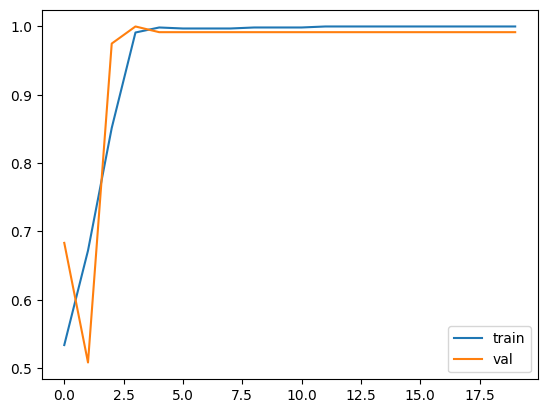

In [ ]:
plt.plot(train_accs, label = 'train')
plt.plot(val_accs, label = 'val')
plt.legend()

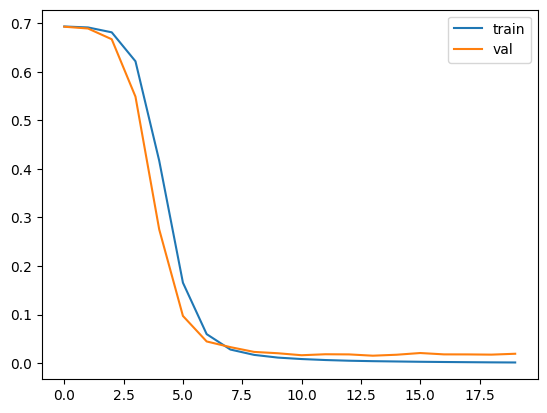

In [ ]:
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()